## Unified Bank Marketing Analysis and Prediction
This notebook provides a comprehensive analysis of the bank marketing dataset. The goal is to predict whether a customer will subscribe to a term deposit. The process includes:
1. **Data Loading and Initial Exploration:** Loading the dataset and getting a first look at the data.
2. **Data Cleaning and Preprocessing:** Cleaning column names, converting data types, and dropping irrelevant columns.
3. **Exploratory Data Analysis (EDA):** Visualizing the data to understand feature distributions and relationships.
4. **Feature Engineering and Preprocessing Pipeline:** Creating a robust pipeline for scaling numeric features and encoding categorical features.
5. **Handling Class Imbalance:** Using SMOTE to address the imbalance in the target variable.
6. **Model Training and Evaluation:** Training and evaluating a suite of classification models.
7. **Results and Visualization:** Comparing model performance using accuracy, ROC AUC scores, and ROC curves.
8. **Model Saving and Prediction:** Saving the best model and demonstrating its use for predictions on new data.

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

### 1. Data Loading and Initial Exploration

In [26]:
notebook_path = Path.cwd()
file_path = notebook_path.parent / 'dataset' / 'bank.csv'
print(f"Loading data from: {file_path}")
data = pd.read_csv(file_path, header=0, sep=';')
data.head()

Loading data from: /home/tisinr/Dev/models/classifier/dataset/bank.csv


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 2. Data Cleaning and Preprocessing

In [27]:
def rename_and_clean(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    # Change data types for faster loading and memory efficiency
    for col in ['response', 'marital_status', 'education', 'job', 'contact', 'month', 'day', 'credit_default', 'housing_loan', 'personal_loan']:
        data[col] = data[col].astype('category')
    # Drop poutcome (many unknowns) and duration (data leakage)
    data.drop(['poutcome', 'duration'], axis=1, inplace=True)
    return data

data = rename_and_clean(data)
print("Data cleaned and preprocessed.")
data.info()

Data cleaned and preprocessed.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             45211 non-null  category
 2   marital_status  45211 non-null  category
 3   education       45211 non-null  category
 4   credit_default  45211 non-null  category
 5   balance         45211 non-null  int64   
 6   housing_loan    45211 non-null  category
 7   personal_loan   45211 non-null  category
 8   contact         45211 non-null  category
 9   day             45211 non-null  category
 10  month           45211 non-null  category
 11  campaign        45211 non-null  int64   
 12  pdays           45211 non-null  int64   
 13  previous        45211 non-null  int64   
 14  response        45211 non-null  category
dtypes: category(10), int64(5)
memory usage: 2.2 MB


### 3. Exploratory Data Analysis (EDA)

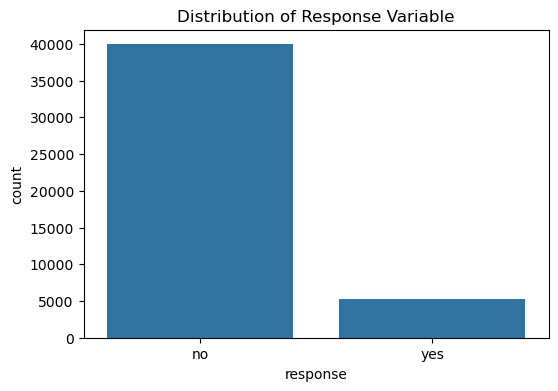

In [28]:
# Distribution of the response variable
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='response')
plt.title('Distribution of Response Variable')
plt.show()

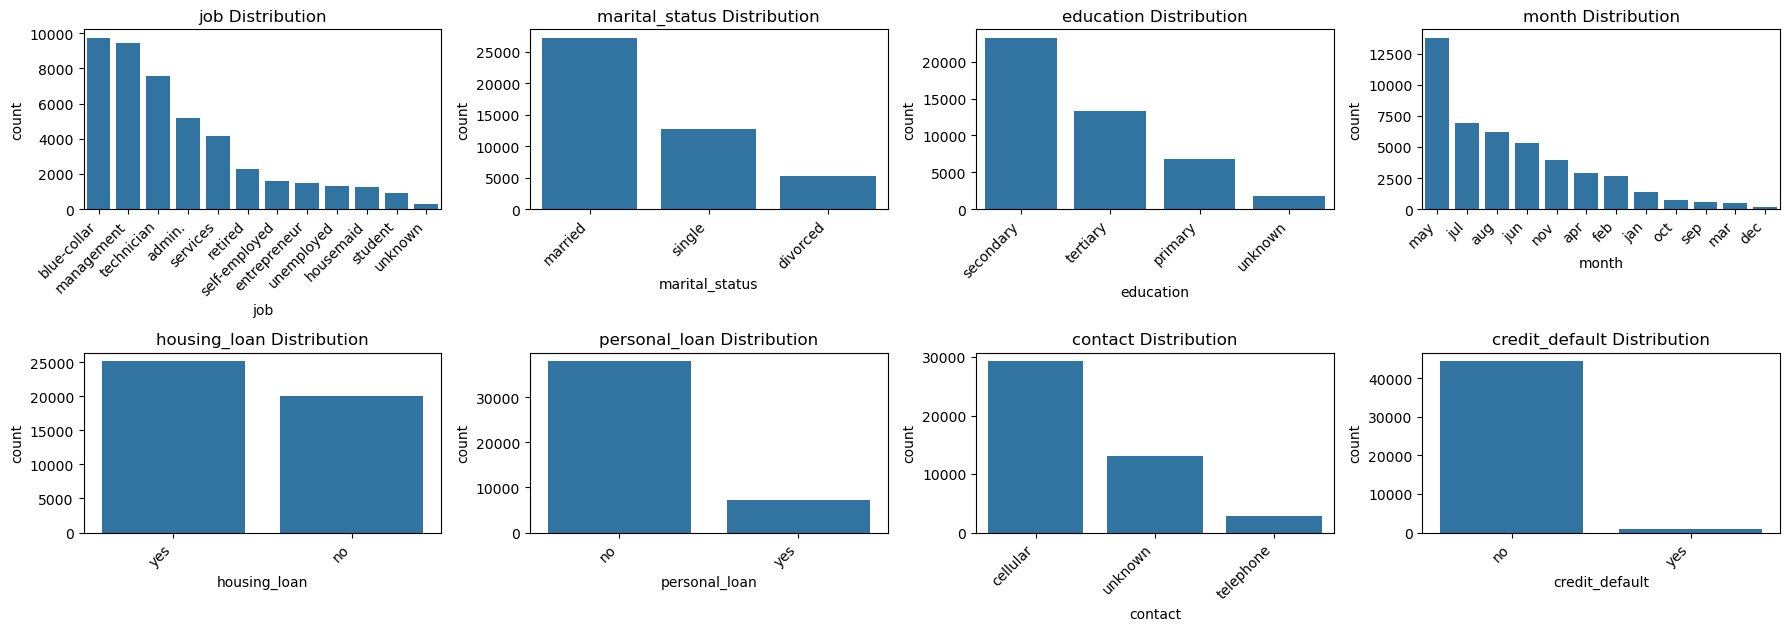

In [29]:
# Distribution of categorical features
categorical_features_for_plot = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'contact', 'credit_default']
plt.figure(figsize=(18, 12))
for i, variable in enumerate(categorical_features_for_plot, 1):
    plt.subplot(4, 4, i)
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

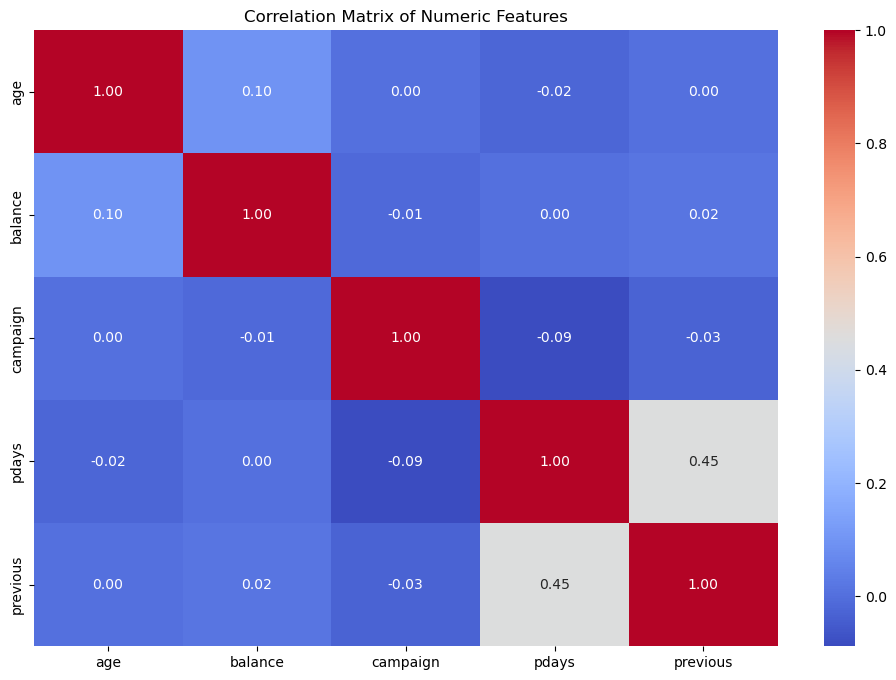

In [30]:
# Correlation matrix for numeric features
numeric_ft = data.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### 4. Feature Engineering and Preprocessing Pipeline

In [31]:
X = data.drop(columns=['response'])
y = data['response']

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pre_pipeline = Pipeline(steps=[('preprocessor', pre_processor)])

### 5. Data Splitting and Handling Class Imbalance

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=78)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train_processed = pre_pipeline.fit_transform(X_train)
X_test_processed = pre_pipeline.transform(X_test)

smote = SMOTE(random_state=78)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

### 6. Model Training and Evaluation

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19178
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


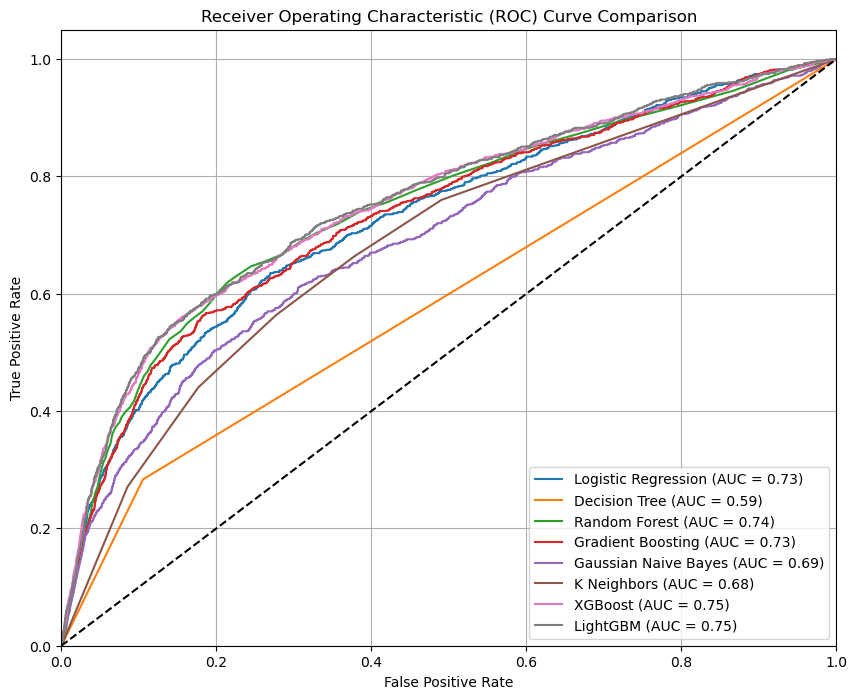

In [33]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=78),
    "Decision Tree": DecisionTreeClassifier(random_state=78),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=78),
    "Gradient Boosting": GradientBoostingClassifier(random_state=78),
    "Gaussian Naive Bayes": GaussianNB(),
    "K Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=78, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=78)
}

results = pd.DataFrame(columns=['Model', 'Accuracy', 'ROC_AUC_Score'])
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Convert data to dense for Gaussian Naive Bayes
    if name == "Gaussian Naive Bayes":
        X_train_to_fit = X_train_resampled.toarray()
        X_test_to_predict = X_test_processed.toarray()
    else:
        X_train_to_fit = X_train_resampled
        X_test_to_predict = X_test_processed

    model.fit(X_train_to_fit, y_train_resampled)
    y_pred = model.predict(X_test_to_predict)
    y_pred_proba = model.predict_proba(X_test_to_predict)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    new_row = pd.DataFrame([{'Model': name, 'Accuracy': accuracy, 'ROC_AUC_Score': roc_auc}])
    results = pd.concat([results, new_row], ignore_index=True)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 7. Results and Visualization

In [34]:
results_sorted = results.sort_values(by='ROC_AUC_Score', ascending=False, ignore_index=True)
print("Model Performance Comparison:")
results_sorted

Model Performance Comparison:


,Model,Accuracy,ROC_AUC_Score
0,LightGBM,0.881013,0.754307
1,XGBoost,0.883556,0.751271
2,Random Forest,0.874710,0.744056
3,Gradient Boosting,0.854362,0.734258
4,Logistic Regression,0.705629,0.728391
5,Gaussian Naive Bayes,0.715028,0.690806
6,K Neighbors,0.704523,0.684830
7,Decision Tree,0.823178,0.589116


### 8. Model Saving and Prediction

In [35]:
best_model_name = results_sorted.iloc[0]['Model']
best_model = models[best_model_name]

model_save_path = notebook_path.parent / 'saved_models'
model_save_path.mkdir(exist_ok=True)

joblib.dump(best_model, model_save_path / 'best_model.pkl')
joblib.dump(pre_pipeline, model_save_path / 'preprocessing_pipeline.pkl')
joblib.dump(label_encoder, model_save_path / 'label_encoder.pkl')

print(f"Best model '{best_model_name}' and preprocessing pipeline saved.")

Best model 'LightGBM' and preprocessing pipeline saved.


In [36]:
# Example of loading the model and making a prediction
loaded_model = joblib.load(model_save_path / 'best_model.pkl')
loaded_pipeline = joblib.load(model_save_path / 'preprocessing_pipeline.pkl')
loaded_label_encoder = joblib.load(model_save_path / 'label_encoder.pkl')

new_data = pd.DataFrame({
    'age': [42],
    'job': ['management'],
    'marital_status': ['married'],
    'education': ['tertiary'],
    'credit_default': ['no'],
    'balance': [2000],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'contact': ['cellular'],
    'day': [5],
    'month': ['may'],
    'campaign': [1],
    'pdays': [-1],
    'previous': [0]
})

# Ensure categorical columns are of type 'category' to match training
for col in categorical_features:
    new_data[col] = new_data[col].astype('category')

new_data_processed = loaded_pipeline.transform(new_data)
prediction_encoded = loaded_model.predict(new_data_processed)
prediction = loaded_label_encoder.inverse_transform(prediction_encoded)

print(f"Prediction for new data: {prediction[0]}")

Prediction for new data: no
